# Goals of McMC method applied to Trough migration: #

**1) To obtain the values of climate parameters (variance, accumulation and lag) that best fit the observed TMP.**
This information can also be obtained by a linear optimization of these parameters.

**2) To quantify how well constrained the climate parameters are**
This information cannot be obtained by just looking at the best fit climate model. Instead, it is necesary to obtain a sample of models that are representative of the Bayesian posterior probability distribution, which is a function of the fit of the model to the data and priors. From this representative sample of models, we can obtain a distribution of values of variance, accumuluation and lag. A distribution of lag values with a small variance, for example, show that the data constrains this value very well and relative small changes in this value cause a relative big change in the fit of the modeled TMP to the observed TMP. 

**3) To understand how the climate parameters are related to each other.**
We can also obtain the covariance between pairs of parameters and see if they have negative or positive relationship
or no relationship at all.

# Content of this notebook: #
**1) Initial guess of climate parameters and corresponding modeled TMP**

**2) Ensemble of climate parameters output of the MCMC and corresponding modeled TMP with uncertainty.**

**3) Measures of convergence**
How do we know the climate parameters obtained in 2) are representative of the posterior and not just random models?
We need to assess convergence. In this notebook, the posterior of models per step (iteration) is plotted and the autocorrelation time is calculated. For steps larger than the autoccorrelation time, independent chains converge to similar values of climated parameters and posterior. We can trust these converged values.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import mars_troughs as mt
import emcee, corner
from mars_troughs import DATAPATHS

The initial guesses for accumulation and variance parameters are good estimates of the best fit values (obtained from previous MCMC runs) but the initial guess for lag is bad (15 mm is very high since the best fit value is around 9 mm). I chose a bad initial guess for lag on purpose in order to show how the MCMC finds a good estimate of lag per iteration. The number of iterations of the MCMC is enough to reach convergence for any initial guess of lag as long as the initial values of the other two parameters are not changed. I haven't tested if this number of steps is enough to reach convergence even when using other guesses of accumulation and variance. 

In [3]:
#crate trough model using initial parameters
#model number =0 is the simplest model 

test_acc_params = [5.4e-7] #parameter 'a', where we use Acc(t) = a * I(t)
acc_model_number = 0
test_lag_params = [15] #lag is constant in time (mm)
lag_model_number = 0
errorbar = np.sqrt(1.6) #errorbar in pixels on the datapoints
tr = mt.Trough(test_acc_params, test_lag_params,
                acc_model_number, lag_model_number,
                errorbar)
#rename times, insolation, accumulation and lag per time
times=tr.ins_times
inst=tr.insolation;
accut=tr.get_accumulation(times)
lagt=tr.get_lag_at_t(times)

#load observed TMP data
xdata,ydata=np.loadtxt(DATAPATHS.TMP, unpack=True)
xdata=xdata*1000 #km to m

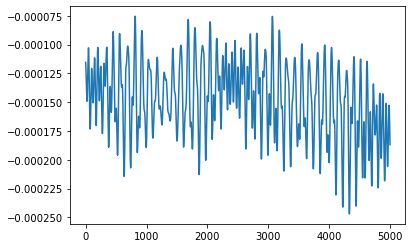

In [6]:
plt.plot(accut)

loglike= -1344.9274881154643


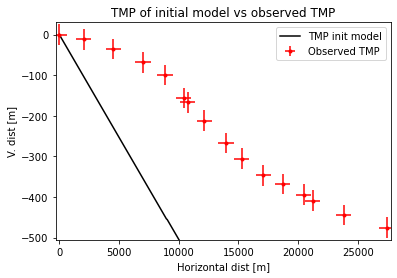

In [7]:
#compare the trajectory of the initial model with the data
plt.plot(tr.get_xt(times), tr.get_yt(times), c='k',label='TMP init model')
xerr, yerr = tr.errorbar*tr.meters_per_pixel
plt.errorbar(x=xdata, xerr=xerr, y=ydata, yerr=yerr, c='r', marker='.', ls='',label='Observed TMP')
xlim = [np.min(xdata)-300, np.max(xdata)+300] #meters
ylim = [np.min(ydata)-30, 30]
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("Horizontal dist [m]")
plt.ylabel("V. dist [m]")
plt.title("TMP of initial model vs observed TMP")
ax=plt.gca()
ax.legend()
print("loglike=", tr.lnlikelihood(xdata,ydata))

The TMP produced by the initial guess of the three climate parameters do not fit the observed TMP. 

In [4]:
#define parameters MCMC
ndim= 3
nwalkers=ndim*4
nburn=200
nsteps=4000
initialParam=np.array([errorbar**2,test_acc_params[0],test_lag_params[0]])


In [5]:
#Define the log likelihood
def ln_likelihood(params):
    variance = params[0]
    if variance < 0: #prior on the variance (i.e. the error bars)
        return -1e99
    acc_params = np.array([params[1]])
    lag_params = np.array([params[2]])
    tr.set_model(acc_params, lag_params, np.sqrt(variance))
    if any(tr.lags_t < 0) or any(tr.lags_t > 20):
        return -1e99
    tr.compute_splines()
    return tr.lnlikelihood(xdata,ydata)

#And the negative of the log likelihood
def neg_ln_likelihood(params):
    return -ln_likelihood(params)


The burn in is the group of the first n iterations of the MCMC run. Usually, models produced during these iterations do not fit the observations well. Because memory is always limited, burn in models are usually discarded. In this notebook, the burn in models are saved in order to visualize how convergence or lacks of convergence might look like. 

In [6]:
#run burn in
p0=[ initialParam + 1e-3*initialParam*np.random.randn(ndim) for i in range(nwalkers)]
burnInSampler = emcee.EnsembleSampler(nwalkers, ndim, ln_likelihood)
_ = burnInSampler.run_mcmc(p0, nburn)

#save values of parameters during burn in
posteriorBurn=burnInSampler.get_log_prob()
varBurn=burnInSampler.chain[:,:,0]
accuBurn=burnInSampler.chain[:,:,1]
lagBurn=burnInSampler.chain[:,:,2]

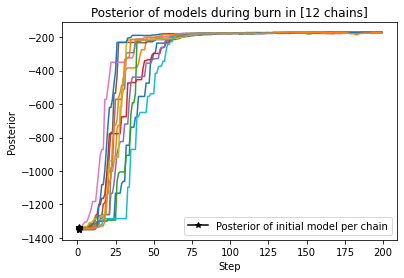

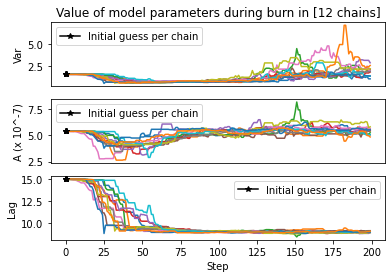

In [7]:
#plot posterior and model parameters during burn in----------------------------------

#plot posterior of models for all chains. 
#Values from different lines come from different chains
plt.figure()
plt.plot(posteriorBurn)
plt.plot(np.ones(12),posteriorBurn[1],marker='*',c='k',label='Posterior of initial model per chain')
plt.xlabel('Step')
plt.ylabel('Posterior')
plt.title('Posterior of models during burn in [12 chains]')
ax=plt.gca()
ax.legend()

#plot value of parameters of models per chain. 
#Values from different lines come from different chains
plt.figure()
plt.subplot(3,1,1)
for i in range(nwalkers):
    plt.plot(varBurn[i,:])
    pi=p0[i]
    plt.plot(pi[0],marker='*',c='k')
plt.plot(pi[0],marker='*',c='k',label='Initial guess per chain')
plt.xticks([], [])
plt.ylabel('Var')
plt.title('Value of model parameters during burn in [12 chains]')
ax=plt.gca()
ax.legend()
plt.subplot(3,1,2)
for i in range(nwalkers):
    plt.plot(accuBurn[i,:]*10**7)
    pi=p0[i]
    plt.plot(pi[1]*10**7,marker='*',c='k')
plt.plot(pi[1]*10**7,marker='*',c='k',label='Initial guess per chain')
plt.xticks([], [])
plt.ylabel('A (x 10^-7)')
ax=plt.gca()
ax.legend()
plt.subplot(3,1,3)
for i in range(nwalkers):
    plt.plot(lagBurn[i,:])
    pi=p0[i]
    plt.plot(pi[2],marker='*',c='k')
plt.plot(pi[2],marker='*',c='k',label='Initial guess per chain')
plt.xlabel('Step')
plt.ylabel('Lag')
ax=plt.gca()
ax.legend()

The posterior increases per iteration and it seems to stabilize or vary less after n number of iterations. The climate parameters vary a lot in the initial iterations and then they also seem to stabilize (individual runs of the MCMC might behave a little different). In general, the behaviour of the posterior and climate parameters might look like convergence but we need to complement this visual "evidence" with an autoccorelation analysis before being sure.

In [8]:
#autocorrelation time
numIterInd=emcee.autocorr.integrated_time(lagBurn[1,:])
numIterInd

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 4;
tau: [23.1019713]

An autocorrelation analysis shows 200 iterations are too few. We should run a longer chain in order to infer the correct values of accumulation, lag and variance. To do that more efficiently, we start new chains using the last of these burn in models as the initial model. 

In [9]:
#run MCMC. This takes around 10 min
pAfterBurn = burnInSampler.chain[:,-1]
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_likelihood)
_ = sampler.run_mcmc(pAfterBurn, nsteps)

In [10]:
#save values obtained after burn in period ends
posteriorAfter=sampler.get_log_prob()
posteriorAfter=posteriorAfter.T
varAfter=sampler.chain[:,:,0];
accuAfter=sampler.chain[:,:,1];
lagAfter=sampler.chain[:,:,2];

#autocorrelation time=how many iterations until we get independent samples?
numStepsInd=int(np.round(emcee.autocorr.integrated_time(lagAfter[1,:])))
numStepsInd

34

Text(0, 0.5, 'Lag')

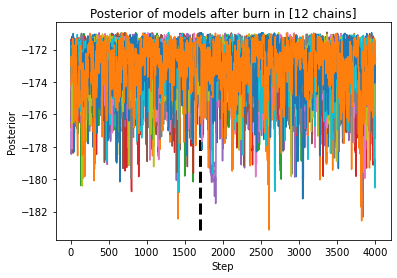

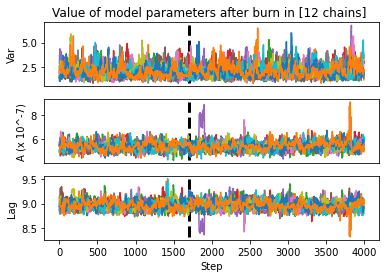

In [11]:
#plot posterior and model parameters after burn in----------------------------------

#plot posterior of models for all chains. 
#Values from different lines come from different chains
plt.figure()
plt.plot(posteriorAfter.T)
plt.vlines(numStepsInd*50,np.min(posteriorAfter),np.max(posteriorAfter),colors='k',linestyle='dashed',linewidth=3,label='independent samples')
plt.xlabel('Step')
plt.ylabel('Posterior')
plt.title('Posterior of models after burn in [12 chains]')

#plot value of parameters of models per chain. 
#Values from different lines come from different chains
plt.figure()
plt.subplot(3,1,1)
for i in range(nwalkers):
    plt.plot(varAfter[i,:])
plt.vlines(numStepsInd*50,np.min(varAfter),np.max(varAfter),colors='k',linestyle='dashed',linewidth=3,label='independent samples')
plt.xticks([], [])
plt.ylabel('Var')
plt.title('Value of model parameters after burn in [12 chains] ')
plt.subplot(3,1,2)
for i in range(nwalkers):
    plt.plot(accuAfter[i,:]*10**7)
plt.vlines(numStepsInd*50,np.min(accuAfter)*10**7,np.max(accuAfter)*10**7,colors='k',linestyle='dashed',linewidth=3,label='independent samples')
plt.xticks([], [])
plt.ylabel('A (x 10^-7)')
plt.subplot(3,1,3)
for i in range(nwalkers):
    plt.plot(lagAfter[i,:])
plt.vlines(numStepsInd*50,np.min(lagAfter),np.max(lagAfter),colors='k',linestyle='dashed',linewidth=3,label='independent samples')
plt.xlabel('Step')
plt.ylabel('Lag')

The posterior and climate parameters now vary less (in the y axis) than they did in the burn in period. They do not show an increasing or decreasing trend either. Chains are considered converged after iteration number 50* numStepsInd (shown by the black vertical line). Values of climate parameters after this line form the output ensemble. 

In [12]:
#get ensemble - remove models before "numIterInd" from models after burn in
                #in order to keep only independent samples 
numModelsEns=len(varAfter.T)-numStepsInd*50
posteriorEns=np.reshape(posteriorAfter[:,numStepsInd*50:],(nwalkers*numModelsEns,))
varEns=np.reshape(varAfter[:,numStepsInd*50:],(nwalkers*numModelsEns,))
accuEns=np.reshape(accuAfter[:,numStepsInd*50:],(nwalkers*numModelsEns,))
lagEns=np.reshape(lagAfter[:,numStepsInd*50:],(nwalkers*numModelsEns,))


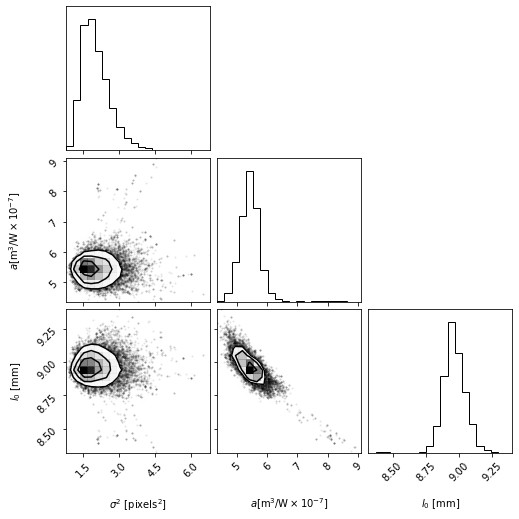

In [13]:
#plot climate parameters in ensemble
auxFig=np.array([varEns,accuEns*1e7,lagEns]).T
fig = corner.corner(auxFig, labels=[r"$\sigma^2\ [{\rm pixels}^2]$", 
   r"$a [{\rm m}^3/{\rm W}\times10^{-7}]$", r"$l_0\ [{\rm mm}]$"])


The distribution of values in the diagonal should be the same independently of the initial values of climate parameters used. In this example, the initial value of lag was 15 mm and the one having the highest posterior is ~ 9 mm. If the initial value used were 5 mm, the one having the highest posterior would be ~ 9 mm anyways. 

In [14]:
#set model to the one in the ensemble having the best fit
bestModel=np.argmax(posteriorEns)
print("Model number" ,bestModel, "has the highest posterior")
bestVar = [varEns[bestModel]]
bestAccu = [accuEns[bestModel]]
bestLag = [lagEns[bestModel]]
tr.set_model(bestAccu, bestLag, np.sqrt(bestVar))

Model number 13164 has the highest posterior


loglike= -170.92485225198345


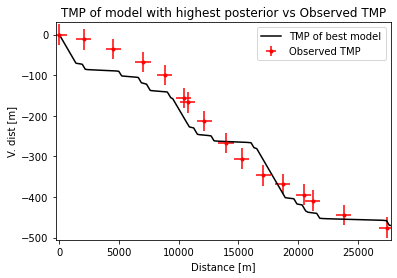

In [15]:
#compare the trajectory of the best fit model with the data
times = tr.ins_times
xtbest=tr.get_xt(times)
ytbest=tr.get_yt(times)
plt.plot(xtbest, ytbest, c='k',label='TMP of best model')
xerr, yerr = tr.errorbar*tr.meters_per_pixel
plt.errorbar(x=xdata, xerr=xerr, y=ydata, yerr=yerr, c='r', marker='.', ls='',label='Observed TMP')
xlim = [np.min(xdata)-300, np.max(xdata)+300] #meters
ylim = [np.min(ydata)-30, 30]
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("Distance [m]")
plt.ylabel("V. dist [m]")
plt.title('TMP of model with highest posterior vs Observed TMP')
ax=plt.gca()
ax.legend()
print("loglike=", np.max(sampler.flatlnprobability))

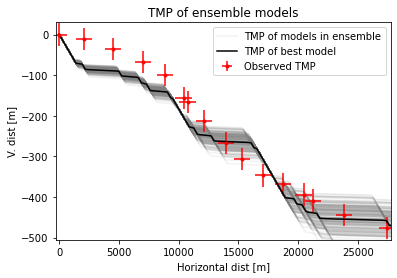

In [16]:
#visualize trajectories from different models in ensemble
for i in range(200):
    model=np.random.randint(0,numModelsEns)
    stdi=np.sqrt(np.array([varEns[model]]))
    acc_params=np.array([accuEns[model]])
    lag_params=np.array([lagEns[model]])
    tr.set_model(acc_params, lag_params, stdi)
    plt.plot(tr.get_xt(times),tr.get_yt(times), c="gray", alpha=0.1,zorder=-1)
plt.plot(tr.get_xt(times),tr.get_yt(times), c="gray", alpha=0.1,zorder=-1,label='TMP of models in ensemble')
plt.plot(xtbest, ytbest, c='k',label='TMP of best model')
xerr, yerr = tr.errorbar*tr.meters_per_pixel
plt.errorbar(x=xdata, xerr=xerr, y=ydata, yerr=yerr, c='r', marker='.', ls='',label='Observed TMP')
xlim = [np.min(xdata)-300, np.max(xdata)+300] #meters
ylim = [np.min(ydata)-30, 30]
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("Horizontal dist [m]")
plt.ylabel("V. dist [m]")
plt.title('TMP of ensemble models')
ax=plt.gca()
ax.legend()

The model with the highest posterior produces a TMP that fits the observed TMP better than the initial model. The gray lines show TMPs produced by other models in the ensemble. From these models, we can obtain statistics about the variation of climate parameters and the sensitivity of the TMP to those variations. These statistics are not included in this notebook.